In [ ]:
# Incase we have to clear all variables
%reset -f

In [1]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt


import time
import heatmap_setup as hm
import numpy as np


from SES_setup import *
from utils import *
from style import *
colourWheel =['#329932',
            '#ff6961',
            'b',
            '#6a3d9a',
            '#fb9a99',
            '#e31a1c',
            '#fdbf6f',
            '#ff7f00',
            '#cab2d6',
            '#6a3d9a',
            '#ffff99',
            '#b15928',
            '#67001f',
            '#b2182b',
            '#d6604d',
            '#f4a582',
            '#fddbc7',
            '#f7f7f7',
            '#d1e5f0',
            '#92c5de',
            '#4393c3',
            '#2166ac',
            '#053061'][::-1]
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 'large'


SES_setup loaded globally


In [2]:
def steadystate_observable(ss_array, PARAMS, observable):
    ss_obs_array = np.zeros(shape=ss_array.shape)
    for y, ss_row in enumerate(ss_array):
        for x, ss_dm in enumerate(ss_row):
            dim, size = ss_dm.dims[0][1::], int(ss_dm.shape[0]/PARAMS['sys_dim'])
            
            nstates, state2idx, idx2state = qt.enr_state_dictionaries(dim, dim[0]+0)
            exc_diff = 0 # function finds the correct exc_diff given some dm
            while nstates != size:
                nstates, state2idx, idx2state = qt.enr_state_dictionaries(dim, dim[0]+exc_diff)
            
            #print exc_diff, dim[0]+exc_diff
            PARAMS.update({'N_1':dim[0], 'N_2':dim[1], 'exc':dim[0]+exc_diff})
            obs_op = make_expectation_operators(PARAMS)[observable]
            #print obs_op.shape, ss_dm.shape
            ss_obs_array[y][x] = (obs_op*ss_dm).tr().real #info_test[y][x]['solution_time']
    return ss_obs_array

# With saved data, we can calculte things differently

def heatmap_loader(num, dir_name="heatmap"):
    # Only loads data of heatmap into memory, does not plot
    directory = 'DATA/'+dir_name+'_'+str(num)
    ss_array = load_obj(directory+'/ss_array')
    PARAMS = load_obj(directory+'/PARAMS')
    info_array = load_obj(directory+'/info_array') # reverse ordering -> lower_N-higher_N
    return ss_array, PARAMS, info_array


def heatmap_plotter(num=-1, plot_SD=True, dir_name="heatmap", 
                     print_params=False, observable='sigma_x', ylim=False):
    
    # If ss_info_params list is provided, then makes heatmap from memory not disk
    
    if num>=0:
        ss_array, PARAMS, info_array = heatmap_loader(num, dir_name=dir_name)
        ss_array_add, PARAMS, info_array_add = heatmap_loader(num, dir_name=dir_name+'_add')
        data = {'non-add.': [ss_array,'solid'], 'add.': [ss_array_add, 'dashed']}
    info = info_array[0][0]
    try:
        # To catch an old bug where these were in "info" not in PARAMS
        keys = ['x_values', 'y_values', 'y_axis_parameters', 'x_axis_parameters']
        PARAMS.update(dict((key, info[key]) for key in keys))
    except Exception as err:
        print "plotting in new style"
    #print info
    
    if plot_SD:
        plot_UD_SD(PARAMS["Gamma_1"], PARAMS["alpha_1"], PARAMS["w0_1"], eps=8000.)
    eta = np.sqrt(PARAMS['bias']**2 + 4*PARAMS['V']**2)
    f, axes = plt.subplots(1,1, figsize=(13,6))
    for key in data.keys():
        if observable=='DS/GS':
            ss_arrayGS = steadystate_observable(data[key][0], PARAMS, 'OO')
            ss_arrayDS = steadystate_observable(data[key][0], PARAMS, 'dark')
            ss_arrayBS = steadystate_observable(data[key][0], PARAMS, 'bright')
            ss_array = (ss_arrayDS+ss_arrayBS)/ss_arrayGS
        else:
            ss_array = steadystate_observable(data[key][0], PARAMS, observable)
        
        ylab = ' = '.join(["$"+l+"$" for l in PARAMS['y_axis_parameters']])
        for i, y_val in enumerate(PARAMS['y_values']):
            x_values = PARAMS['x_values']

            lbl = ylab+"="+"{:0.1f}".format(y_val)
            if key == 'add.':
                lbl = None
            axes.plot(x_values, ss_array[i], label=lbl, 
                      linestyle=data[key][1], color=colourWheel[i*8])
            
        if print_params:
            print_PARAMS(PARAMS)
        labs = ("$\\"+l+"$" for l in PARAMS['x_axis_parameters'])
        xlab = ' , '.join(labs)
        
        plt.xlabel(xlab+" (cm$^{-1}$)")
        #plt.xlabel(', '.join(PARAMS['x_axis_parameters']))
        try:
            plt.ylabel(r"Steadystate "+make_expectation_labels()[observable])
        except:
            plt.ylabel(r"Steadystate "+observable)
    #plt.ylabel(', '.join(info['y_axis_parameters']))
    plt.legend()
    #plt.grid()
    plt.xlim(x_values[0], x_values[-1])
    if ylim:
        plt.ylim(ylim[0], ylim[-1])
    plot_filename = 'PLOTS/'+dir_name+'_'+observable+'_'+str(num)+'.pdf'
    plt.savefig(plot_filename,bbox_inches='tight')
    plt.show()
    print "saved at {}".format(plot_filename)

# Example of loading data to memory
"""ss_info_params = [ss_array, info_array, PARAMS]

heatmap_plotter(ss_info_params=ss_info_params, plot_SD=False,
                print_params=False, observable='sigma_x')
heatmap_plotter(num=5, plot_SD=False, dir_name="heatmap_excvN",
                print_params=False, observable='sigma_x')"""

'ss_info_params = [ss_array, info_array, PARAMS]\n\nheatmap_plotter(ss_info_params=ss_info_params, plot_SD=False,\n                print_params=False, observable=\'sigma_x\')\nheatmap_plotter(num=5, plot_SD=False, dir_name="heatmap_excvN",\n                print_params=False, observable=\'sigma_x\')'

# Environments with different parity $\alpha_1 = -\alpha_2$

/Users/henrymaguire/.pyenv/versions/2.7.15/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


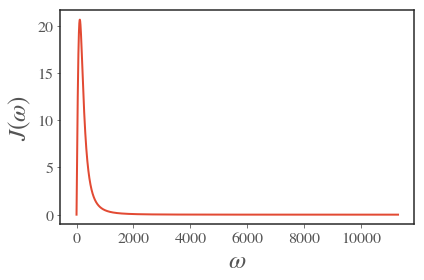

Gap is 180.350062725. Phonon thermal energy is 208.5. Phonon SD peak is 115.01150115. N=7.
[1.00000000e-02 2.78255940e-02 7.74263683e-02 2.15443469e-01
 5.99484250e-01 1.66810054e+00 4.64158883e+00 1.29154967e+01
 3.59381366e+01 1.00000000e+02]
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[    0.        0.        0.   ]
 [    0.    11372.355    80.655]
 [    0.       80.655 11291.7  ]]
Steady state for 2 took 0.008 seconds with direct, OO changed by 53.4115%
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[    0.        0.        0.   ]
 [    0.    11372.355    80.655]
 [    0.       80.655 11291.7  ]]
Steady state for 3 took 0.020 seconds with direct, OO changed by 4.5314%
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[    0.        0.        0.   ]
 [    0.    11372.355    80.655]
 [    0.       80.655 11291.7  ]]
Steady state for 4 took 0.292 seconds 

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[    0.        0.        0.   ]
 [    0.    11372.355    80.655]
 [    0.       80.655 11291.7  ]]
Steady state for 6 took 17.934 seconds with direct, OO changed by 0.0155%
calculation converged - 35.9, 77.0 (9/20)
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[    0.        0.        0.   ]
 [    0.    11372.355    80.655]
 [    0.       80.655 11291.7  ]]
Steady state for 2 took 0.002 seconds with direct, OO changed by 17427.9814%
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[    0.        0.        0.   ]
 [    0.    11372.355    80.655]
 [    0.       80.655 11291.7  ]]
Steady state for 3 took 0.018 seconds with direct, OO changed by 7.6034%
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[    0.        0.        0.   ]
 [    0.    11372.355    80.655]
 [    0.

Steady state for 4 took 0.300 seconds with direct, OO changed by 0.0402%
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[    0.        0.        0.   ]
 [    0.    11372.355    80.655]
 [    0.       80.655 11291.7  ]]
Steady state for 5 took 2.817 seconds with direct, OO changed by 0.0233%
calculation converged - 12.9, 300.0 (18/20)
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[    0.        0.        0.   ]
 [    0.    11372.355    80.655]
 [    0.       80.655 11291.7  ]]
Steady state for 2 took 0.002 seconds with direct, OO changed by 30.3739%
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[    0.        0.        0.   ]
 [    0.    11372.355    80.655]
 [    0.       80.655 11291.7  ]]
Steady state for 3 took 0.023 seconds with direct, OO changed by 0.1720%
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 

"\nss_array, info_array = hm.heat_map_calculator(PARAMS,\n                            x_axis_parameters=['alpha_1', 'alpha_2'],\n                            y_axis_parameters=['T_1', 'T_2'],\n                            x_values=x_values,\n                            y_values=y_values,\n                            dir_name=dirname, save_data=True,\n                            persistent=False, method='direct', threshold=1e-9, \n                            conv_percent_tol=0.025, conv_obs='OO', additive=False)"

In [3]:
reload(hm)
w_2 = 1.4*ev_to_inv_cm
bias = 0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 0.01*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 100./pi
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =7
wc = 100.
w_0 = 200.
site_basis = True
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=False, exc_diff=N, parity_flip=True)

x_values = np.logspace(-2, np.log10(100), 10, endpoint=True)
print x_values
y_values = [77, 300] #np.linspace(77,300, 2)
dirname = 'heatmap_TphvAlpha_phased'

ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname+'_add', save_data=True,
                            persistent=False, method='direct', threshold=1e-9, 
                            conv_percent_tol=0.025, conv_obs='OO', additive=True)
"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname, save_data=True,
                            persistent=False, method='direct', threshold=1e-9, 
                            conv_percent_tol=0.025, conv_obs='OO', additive=False)"""
#DATA/heatmap_TphvAlpha_phased_2

plotting in new style


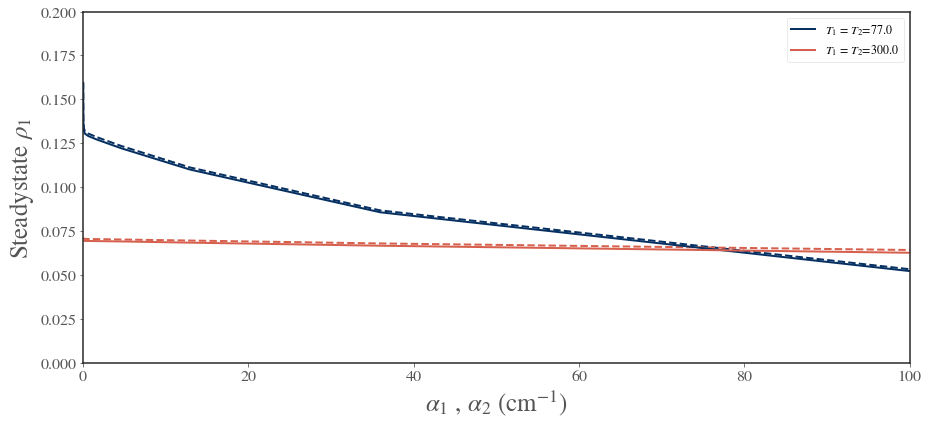

saved at PLOTS/heatmap_TphvAlpha_phased_XO_2.pdf
plotting in new style


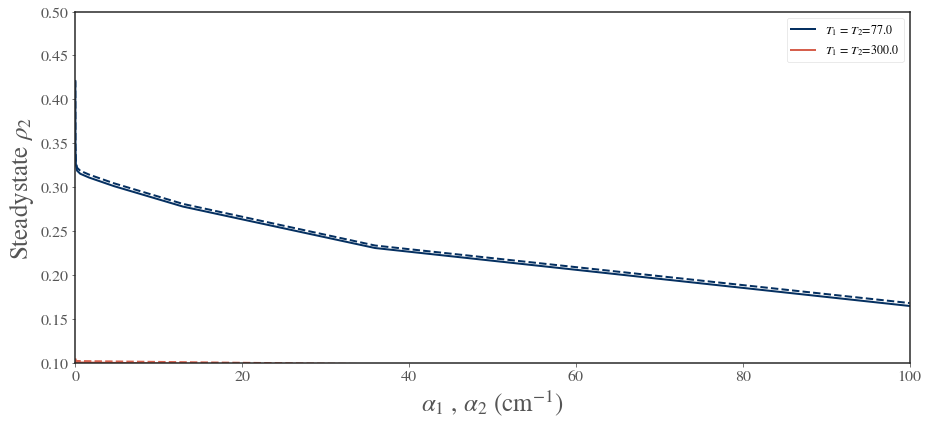

saved at PLOTS/heatmap_TphvAlpha_phased_OX_2.pdf
plotting in new style


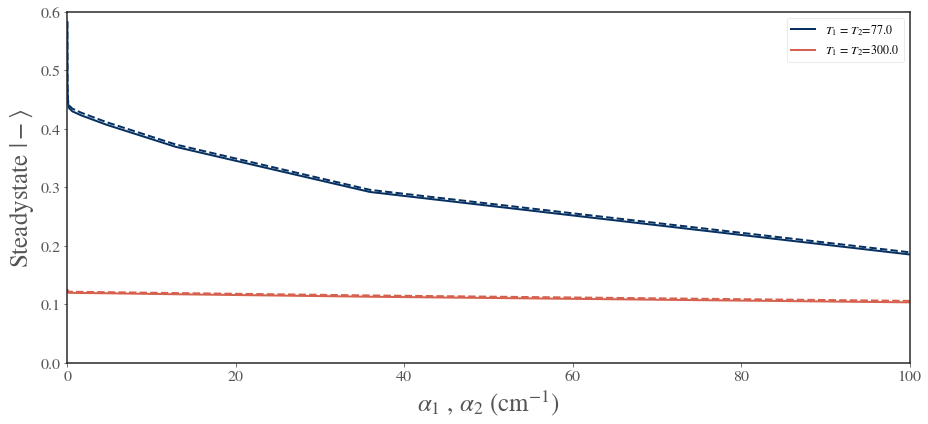

saved at PLOTS/heatmap_TphvAlpha_phased_dark_2.pdf
plotting in new style


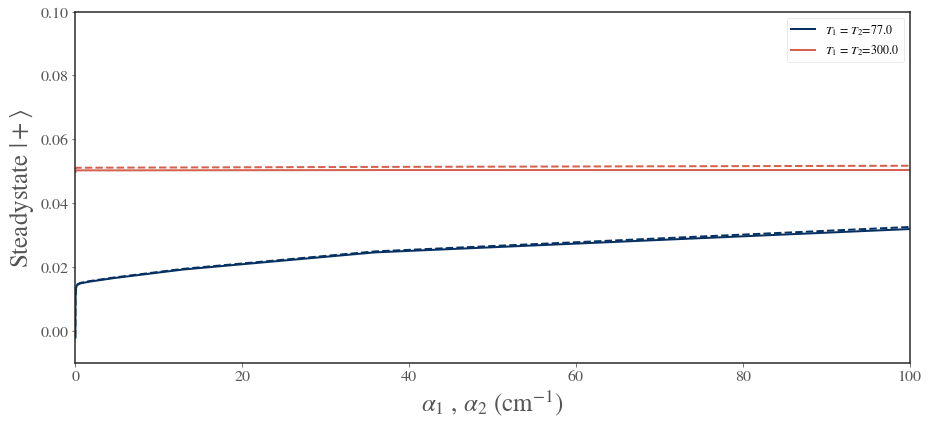

saved at PLOTS/heatmap_TphvAlpha_phased_bright_2.pdf
plotting in new style


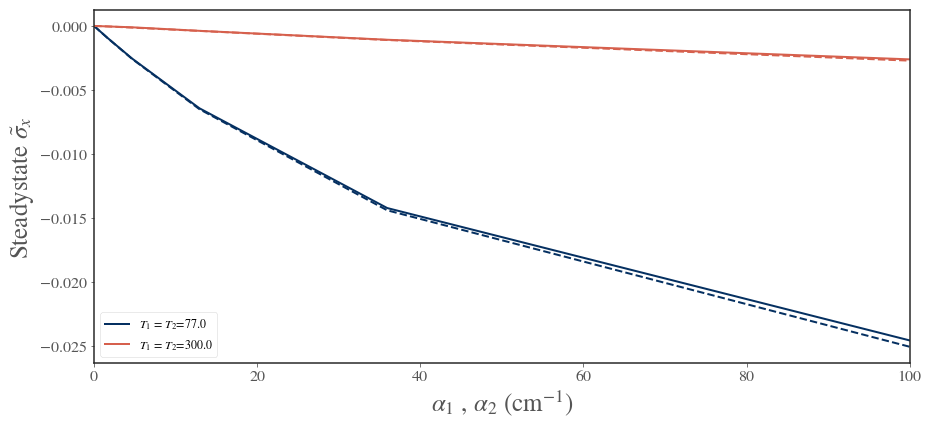

saved at PLOTS/heatmap_TphvAlpha_phased_eig_x_2.pdf


In [4]:
num=2
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='XO', ylim=[0,0.2])
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='OX', ylim=[0.1,0.5])
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='dark', ylim=[0,0.6])
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='bright', ylim=[-0.01,0.1])
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_x')

### Uncoupled monomers

These get updated dynamically by the various functions. `SES_setup.PARAMS_setup` just imposes the relevant symmetry behind the scenes so the API is clean and so that we can reuse code for dimer case - e.g. $\alpha_1 = \alpha_2$, no doubly excited state.

/Users/henrymaguire/.pyenv/versions/2.7.15/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


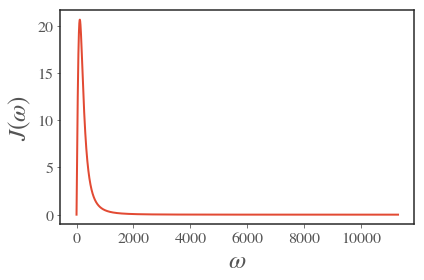

Gap is 161.31. Phonon thermal energy is 208.5. Phonon SD peak is 115.01150115. N=7.
[1.00000000e-02 2.78255940e-02 7.74263683e-02 2.15443469e-01
 5.99484250e-01 1.66810054e+00 4.64158883e+00 1.29154967e+01
 3.59381366e+01 1.00000000e+02]
Steady state for 4 took 0.177 seconds with direct, OO changed by 272.2418%
calculation converged - 0.0, 77.0 (1/20)
Steady state for 4 took 0.172 seconds with direct, OO changed by 1000.9272%
calculation converged - 0.0, 77.0 (2/20)
Steady state for 4 took 0.173 seconds with direct, OO changed by 296.9850%
calculation converged - 0.1, 77.0 (3/20)
Steady state for 4 took 0.159 seconds with direct, OO changed by 121.9227%
calculation converged - 0.2, 77.0 (4/20)
Steady state for 4 took 0.175 seconds with direct, OO changed by 76.5742%
calculation converged - 0.6, 77.0 (5/20)
Steady state for 4 took 0.172 seconds with direct, OO changed by 101.7186%
Steady state for 5 took 1.440 seconds with direct, OO changed by 0.0000%
calculation converged - 1.7, 77.0 

"\nss_array, info_array = hm.heat_map_calculator(PARAMS,\n                            x_axis_parameters=['alpha_1', 'alpha_2'],\n                            y_axis_parameters=['T_1', 'T_2'],\n                            x_values=x_values,\n                            y_values=y_values,\n                            dir_name=dirname, save_data=True,\n                            persistent=False, method='direct', threshold=1e-12, \n                            conv_percent_tol=0.01, conv_obs='OO', additive=False)\n"

In [3]:

reload(hm)

w_2 = 1.4*ev_to_inv_cm
bias = 0.02*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 0.0*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 100./pi
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =7
wc = 100.
w_0 = 200.
site_basis = True
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=False, exc_diff=N)

x_values = np.logspace(-2, np.log10(100), 10, endpoint=True)
print x_values
y_values = [77, 300] #np.linspace(77,300, 2)
dirname = 'heatmap_TphvAlpha_uncoupled'

ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname+'_add', save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                                              conv_percent_tol=0.025, conv_obs='OO', additive=True)
"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname, save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                            conv_percent_tol=0.01, conv_obs='OO', additive=False)
"""
#DATA/heatmap_TphvAlpha_uncoupled_6

plotting in new style


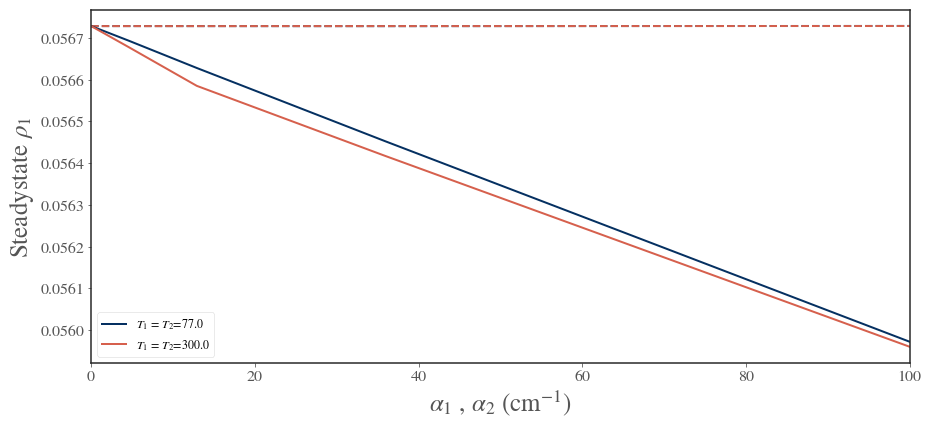

saved at PLOTS/heatmap_TphvAlpha_uncoupled_XO_6.pdf
plotting in new style


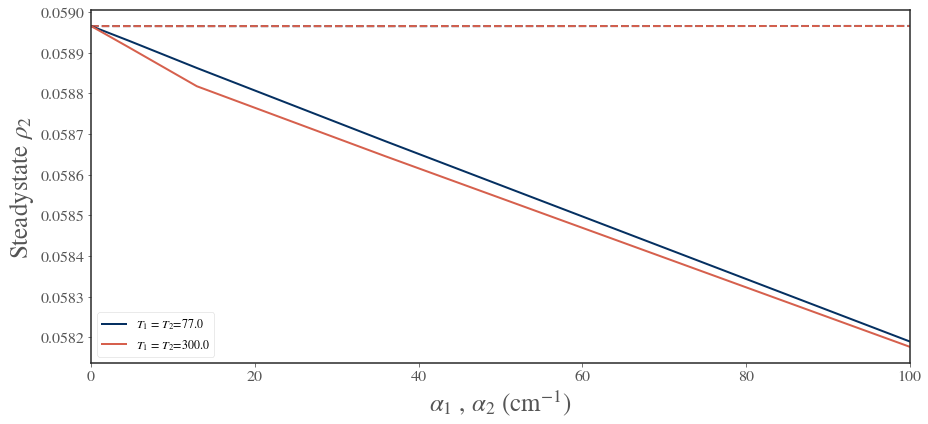

saved at PLOTS/heatmap_TphvAlpha_uncoupled_OX_6.pdf


In [4]:
num=6
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='XO')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='OX')

In [ ]:
H, L = get_H_and_L(PARAMS)


In [ ]:
eta = np.sqrt(PARAMS['bias']**2 + 4*PARAMS['V']**2)
print (2*PARAMS['V']/eta)
print (PARAMS['bias']/eta)
print (1/np.sqrt(2))

In [ ]:
np.linspace(200, 600, 5, endpoint=False)

In [ ]:
np.log(0.0001)
np.logspace(-5, 2, 10, endpoint=False)

## Heterodimer
Shouldn't increasing the phonon coupling strength lead to suppression of ground state population?

In [4]:
reload(hm)
w_2 = 1.4*ev_to_inv_cm
bias=0.01*ev_to_inv_cm
V=0.01*ev_to_inv_cm
alpha = 200./pi
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4
wc = 100.
w_0 = 200.
site_basis = True
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=2*N)

x_values = np.logspace(-2, np.log10(100), 10, endpoint=True)
print x_values
y_values = [77, 300] #np.linspace(77,300, 2)

"""

ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name='heatmap_TphvAlpha', save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                                              conv_percent_tol=0.1, conv_obs='OO')
"""
dirname = 'heatmap_TphvAlpha_hetero'

[1.00000000e-02 2.78255940e-02 7.74263683e-02 2.15443469e-01
 5.99484250e-01 1.66810054e+00 4.64158883e+00 1.29154967e+01
 3.59381366e+01 1.00000000e+02]


In [ ]:
ss_array, PARAMS, info_array = heatmap_loader(16, dir_name="heatmap_TphvAlpha")
print zip(PARAMS['x_values'], steadystate_observable(ss_array, PARAMS, 'OO')[0])

In [5]:

reload(hm)
"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname, save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                            conv_percent_tol=0.025, conv_obs='OO', additive=False)
"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname+'_add', save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                                              conv_percent_tol=0.025, conv_obs='OO', additive=True)

Steady state for 2 took 0.002 seconds with direct, OO changed by 37.1740%
Steady state for 3 took 0.019 seconds with direct, OO changed by 4.5314%
Steady state for 4 took 0.295 seconds with direct, OO changed by 0.2060%
calculation converged - 0.0, 77.0 (1/20)
Steady state for 2 took 0.002 seconds with direct, OO changed by 20.7747%
Steady state for 3 took 0.020 seconds with direct, OO changed by 0.7871%
Steady state for 4 took 0.311 seconds with direct, OO changed by 0.0382%
calculation converged - 0.0, 77.0 (2/20)
Steady state for 2 took 0.002 seconds with direct, OO changed by 55.4531%
Steady state for 3 took 0.018 seconds with direct, OO changed by 0.2345%
Steady state for 4 took 0.306 seconds with direct, OO changed by 0.0115%
calculation converged - 0.1, 77.0 (3/20)
Steady state for 2 took 0.001 seconds with direct, OO changed by 5493.9288%
Steady state for 3 took 0.020 seconds with direct, OO changed by 0.0879%
Steady state for 4 took 0.300 seconds with direct, OO changed by 0.0

plotting in new style


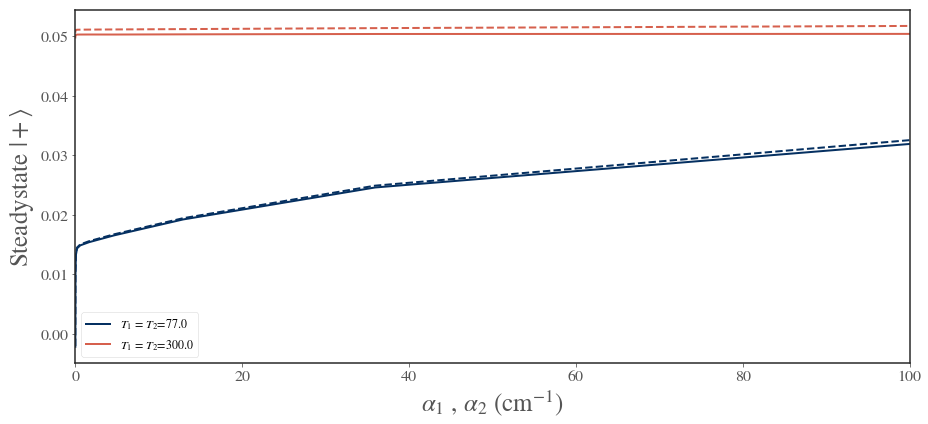

saved at PLOTS/heatmap_TphvAlpha_hetero_bright_4.pdf
plotting in new style


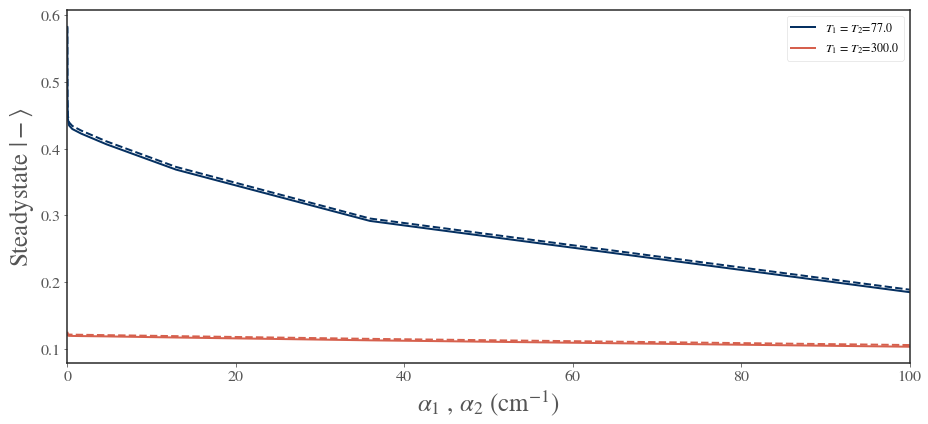

saved at PLOTS/heatmap_TphvAlpha_hetero_dark_4.pdf
plotting in new style


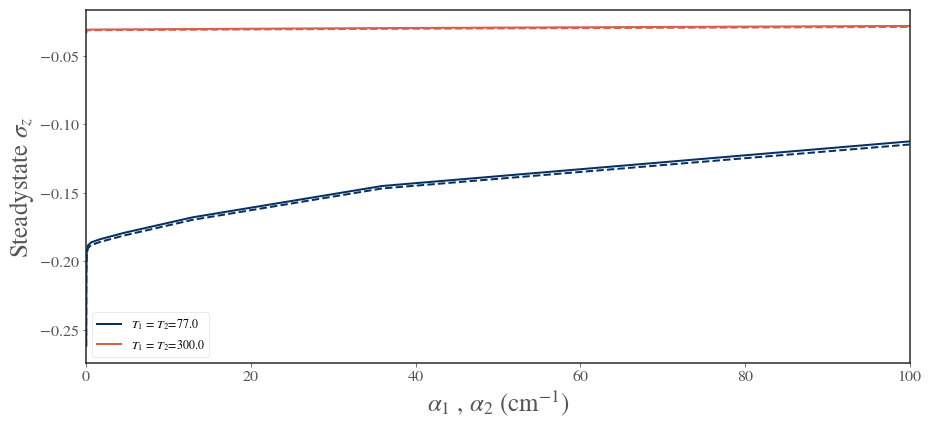

saved at PLOTS/heatmap_TphvAlpha_hetero_sigma_z_4.pdf
plotting in new style


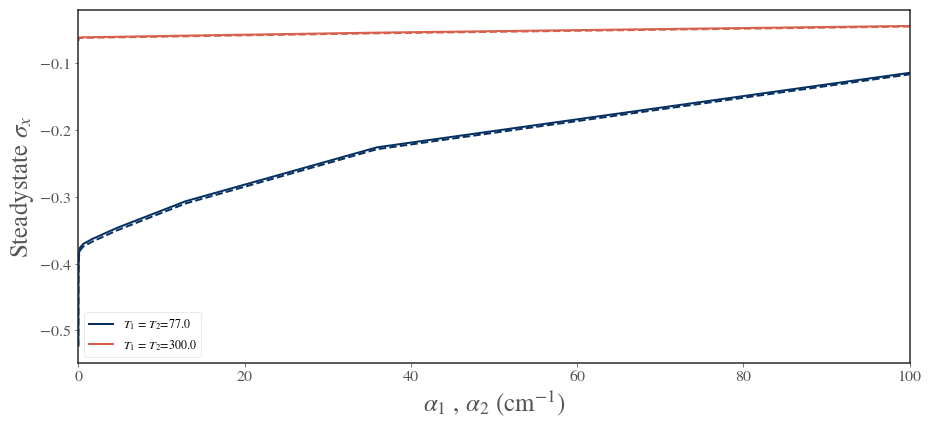

saved at PLOTS/heatmap_TphvAlpha_hetero_sigma_x_4.pdf
plotting in new style


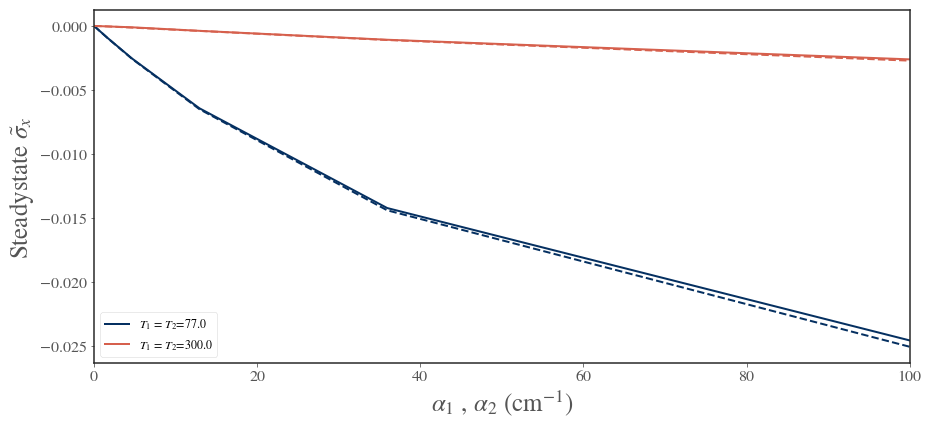

saved at PLOTS/heatmap_TphvAlpha_hetero_eig_x_4.pdf


In [7]:
num = 4
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='bright')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='dark')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='sigma_z')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='sigma_x')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_x')

In [ ]:
num = 20
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='DS/GS')

heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='OO')

heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='XO')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='OX')

heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_x')
"""heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='eig_x_equiv')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='eig_y')"""




# Homodimer

In [3]:
reload(hm)
w_2 = 1.40*ev_to_inv_cm
bias= 0 #0.01*ev_to_inv_cm
V=0.01*ev_to_inv_cm
alpha = 200./pi
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4
wc = 100.
w_0 = 200.
site_basis = True
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=2*N)

x_values = np.logspace(-2, np.log10(100), 10, endpoint=True)
#x_values[0] = 0
y_values = [77, 300] #np.linspace(77,300, 2)


In [9]:
print inv_ps_to_inv_cm*10**(-3)
print w_0/ev_to_inv_cm
print Gamma/ev_to_inv_cm

0.005309
0.0247969747691
0.0495939495382


In [16]:
print (x_values)

[1.00000000e-05 5.01187234e-05 2.51188643e-04 1.25892541e-03
 6.30957344e-03 3.16227766e-02 1.58489319e-01 7.94328235e-01
 3.98107171e+00 1.99526231e+01]


In [12]:
dirname = 'heatmap_TphvAlpha_homo'
reload(hm)

ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname, save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                                              conv_percent_tol=0.025, conv_obs='OO', additive=False)

"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1', 'alpha_2'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname+'_add', save_data=True,
                            persistent=False, method='direct', threshold=1e-12, 
                                              conv_percent_tol=0.025, conv_obs='OO', additive=True)"""

Steady state for 2 took 0.002 seconds with direct, OO changed by 51.8576%
Steady state for 3 took 0.022 seconds with direct, OO changed by 0.0019%
calculation converged - 0.0, 77.0 (1/20)
Steady state for 2 took 0.001 seconds with direct, OO changed by 242.8236%
Steady state for 3 took 0.024 seconds with direct, OO changed by 0.0036%
calculation converged - 0.0, 77.0 (2/20)
Steady state for 2 took 0.002 seconds with direct, OO changed by 54.3242%
Steady state for 3 took 0.027 seconds with direct, OO changed by 0.0085%
calculation converged - 0.1, 77.0 (3/20)
Steady state for 2 took 0.001 seconds with direct, OO changed by 9.1339%
Steady state for 3 took 0.022 seconds with direct, OO changed by 0.0224%
calculation converged - 0.2, 77.0 (4/20)
Steady state for 2 took 0.001 seconds with direct, OO changed by 108.1899%
Steady state for 3 took 0.025 seconds with direct, OO changed by 0.0646%
Steady state for 4 took 0.417 seconds with direct, OO changed by 0.0027%
calculation converged - 0.6

"\nss_array, info_array = hm.heat_map_calculator(PARAMS,\n                            x_axis_parameters=['alpha_1', 'alpha_2'],\n                            y_axis_parameters=['T_1', 'T_2'],\n                            x_values=x_values,\n                            y_values=y_values,\n                            dir_name=dirname+'_add', save_data=True,\n                            persistent=False, method='direct', threshold=1e-12, \n                                              conv_percent_tol=0.025, conv_obs='OO', additive=True)"

plotting in new style


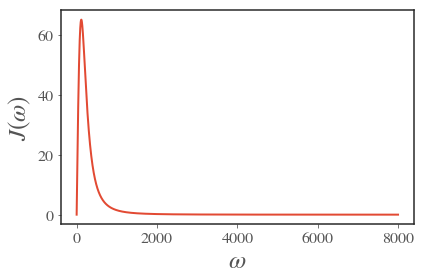

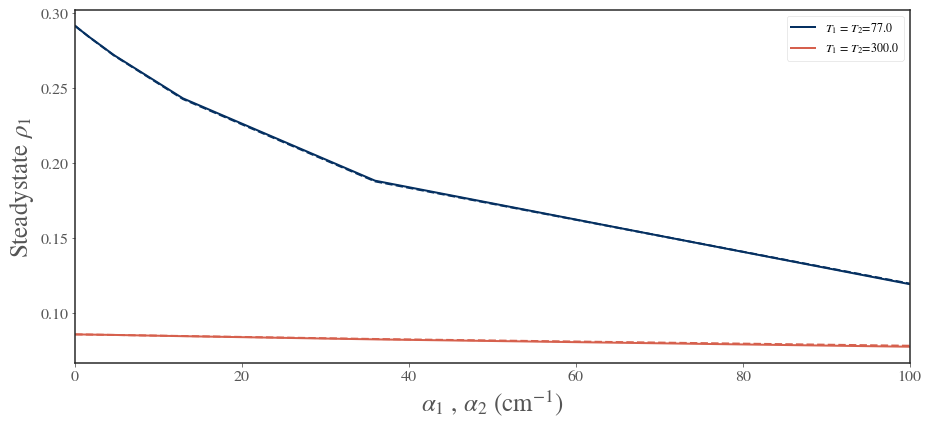

saved at PLOTS/heatmap_TphvAlpha_homo_XO_2.pdf
plotting in new style


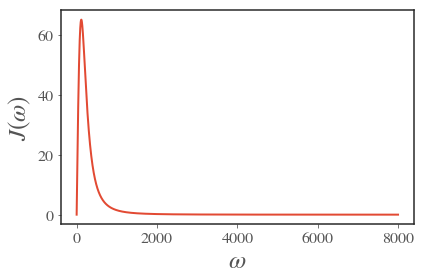

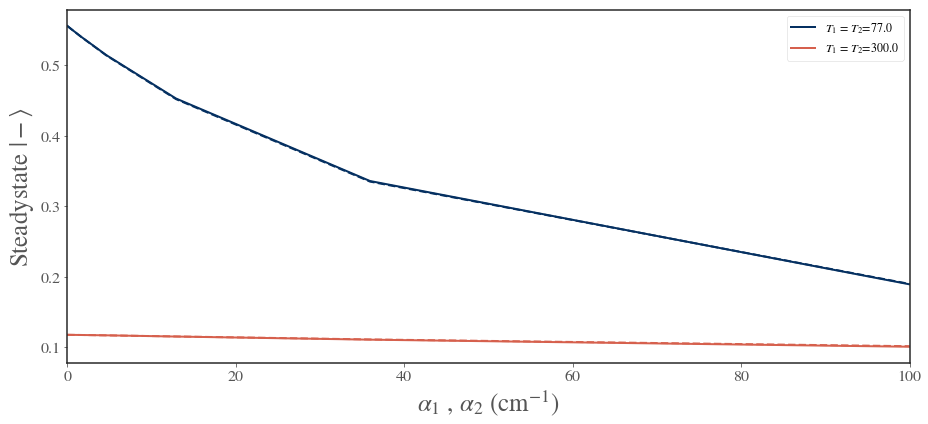

saved at PLOTS/heatmap_TphvAlpha_homo_dark_2.pdf
plotting in new style


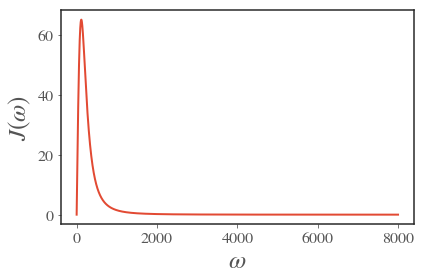

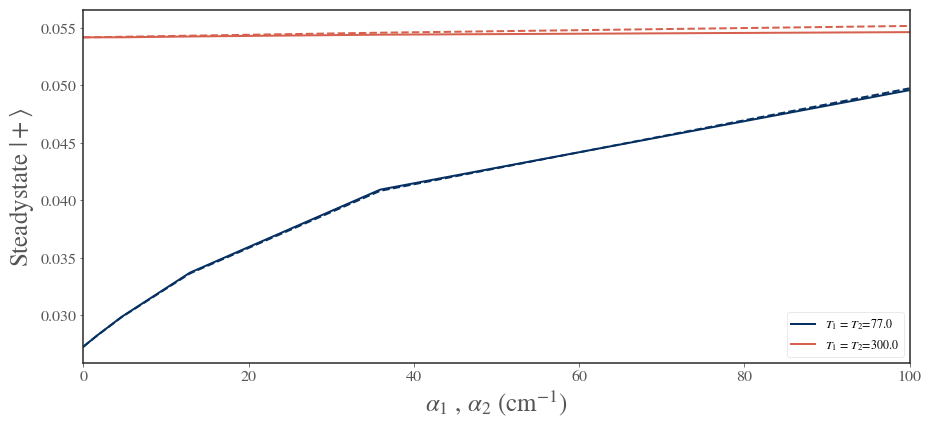

saved at PLOTS/heatmap_TphvAlpha_homo_bright_2.pdf
plotting in new style


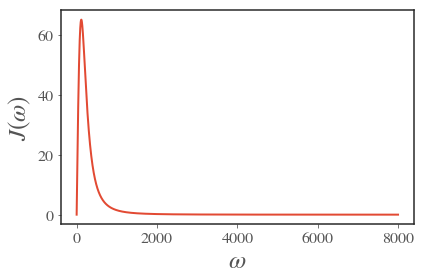

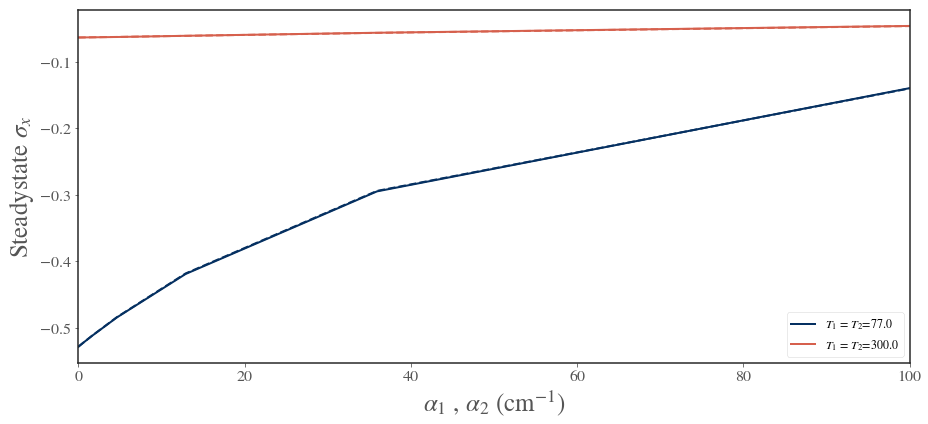

saved at PLOTS/heatmap_TphvAlpha_homo_sigma_x_2.pdf


In [13]:
def steadystate_observable(ss_array, PARAMS, observable):
    ss_obs_array = np.zeros(shape=ss_array.shape)
    for y, ss_row in enumerate(ss_array):
        for x, ss_dm in enumerate(ss_row):
            dim, size = ss_dm.dims[0][1::], int(ss_dm.shape[0]/PARAMS['sys_dim'])
            
            nstates, state2idx, idx2state = qt.enr_state_dictionaries(dim, dim[0]+0)
            exc_diff = 0 # function finds the correct exc_diff given some dm
            while nstates != size:
                nstates, state2idx, idx2state = qt.enr_state_dictionaries(dim, dim[0]+exc_diff)
            
            #print exc_diff, dim[0]+exc_diff
            PARAMS.update({'N_1':dim[0], 'N_2':dim[1], 'exc':dim[0]+exc_diff})
            obs_op = make_expectation_operators(PARAMS)[observable]
            #print obs_op.shape, ss_dm.shape
            ss_obs_array[y][x] = (obs_op*ss_dm).tr().real #info_test[y][x]['solution_time']
    return ss_obs_array

# With saved data, we can calculte things differently

def heatmap_loader(num, dir_name="heatmap"):
    # Only loads data of heatmap into memory, does not plot
    directory = 'DATA/'+dir_name+'_'+str(num)
    ss_array = load_obj(directory+'/ss_array')
    PARAMS = load_obj(directory+'/PARAMS')
    info_array = load_obj(directory+'/info_array') # reverse ordering -> lower_N-higher_N
    return ss_array, PARAMS, info_array

num = 2
heatmap_plotter(num=num, dir_name=dirname, 
                     print_params=False, observable='XO')
heatmap_plotter(num=num, dir_name=dirname, 
                     print_params=False, observable='dark')
heatmap_plotter(num=num, dir_name=dirname, 
                     print_params=False, observable='bright')
heatmap_plotter(num=num, dir_name=dirname, 
                     print_params=False, observable='sigma_x')


In [ ]:
num = 19

heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=True, observable='DS/GS')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='bright')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='dark')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='OO')

heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='XO')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='OX')

heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='eig_x')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='eig_x_equiv')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='eig_y')

heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='sigma_z')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='sigma_x')
heatmap_plotter(num=num, plot_SD=False, dir_name="heatmap_TphvAlpha",
                print_params=False, observable='sigma_y')

In [ ]:
num = 1
dir_name = 'heatmap_TphvAlpha_a19'
hm = heatmap_loader(19, dir_name='heatmap_TphvAlpha')
hm2 = heatmap_loader(1, dir_name='heatmap_TphvAlpha_a19')
print hm[0]
"""heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=True, observable='DS/GS')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='bright')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='dark')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='OO')

heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='XO')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='OX')

heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='eig_x')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='eig_x_equiv')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='eig_y')

heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='sigma_z')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='sigma_x')
heatmap_plotter(num=num, plot_SD=False, dir_name=dir_name,
                print_params=False, observable='sigma_y')"""

# Asymmetrical phonon environments

In [3]:
reload(hm)
w_2 = 1.40*ev_to_inv_cm
bias= 0 #0.01*ev_to_inv_cm
V=0.01*ev_to_inv_cm
alpha = 5.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4
wc = 100.
w_0 = 200.
site_basis = True
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=6000., T_ph =300., alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=2*N)

x_values = np.logspace(-2, np.log10(100), 20, endpoint=True)
#x_values[0] = 0
y_values = [77, 300] #np.linspace(77,300, 2)
dirname = "heatmap_TphvAlpha_assymmetrical"
"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname, save_data=True,
                            persistent=False, method='direct', threshold=1e-7, 
                                              conv_percent_tol=0.025, conv_obs='OO')
"""
ss_array, info_array = hm.heat_map_calculator(PARAMS,
                            x_axis_parameters=['alpha_1'],
                            y_axis_parameters=['T_1', 'T_2'],
                            x_values=x_values,
                            y_values=y_values,
                            dir_name=dirname, save_data=True,
                            persistent=False, method='direct', threshold=1e-7, 
                                              conv_percent_tol=0.025, conv_obs='OO', additive=True)

Steady state for 2 took 0.001 seconds with direct, OO changed by 41.4745%
Steady state for 3 took 0.021 seconds with direct, OO changed by 0.4604%
Steady state for 4 took 0.300 seconds with direct, OO changed by 0.0331%
calculation converged - 0.0, 77.0 (1/40)
Steady state for 2 took 0.002 seconds with direct, OO changed by 15.2687%
Steady state for 3 took 0.018 seconds with direct, OO changed by 0.4606%
Steady state for 4 took 0.288 seconds with direct, OO changed by 0.0331%
calculation converged - 0.0, 77.0 (2/40)
Steady state for 2 took 0.002 seconds with direct, OO changed by 13.1267%
Steady state for 3 took 0.022 seconds with direct, OO changed by 0.4610%
Steady state for 4 took 0.290 seconds with direct, OO changed by 0.0331%
calculation converged - 0.0, 77.0 (3/40)
Steady state for 2 took 0.002 seconds with direct, OO changed by 49.7723%
Steady state for 3 took 0.019 seconds with direct, OO changed by 0.4615%
Steady state for 4 took 0.288 seconds with direct, OO changed by 0.033

Steady state for 2 took 0.001 seconds with direct, OO changed by 48.6967%
Steady state for 3 took 0.019 seconds with direct, OO changed by 0.0164%
calculation converged - 0.8, 300.0 (30/40)
Steady state for 2 took 0.001 seconds with direct, OO changed by 80.1078%
Steady state for 3 took 0.021 seconds with direct, OO changed by 0.0178%
calculation converged - 1.3, 300.0 (31/40)
Steady state for 2 took 0.002 seconds with direct, OO changed by 176.6437%
Steady state for 3 took 0.018 seconds with direct, OO changed by 0.0200%
calculation converged - 2.1, 300.0 (32/40)
Steady state for 2 took 0.001 seconds with direct, OO changed by 1430.0624%
Steady state for 3 took 0.019 seconds with direct, OO changed by 0.0236%
calculation converged - 3.4, 300.0 (33/40)
Steady state for 2 took 0.002 seconds with direct, OO changed by 33.0489%
Steady state for 3 took 0.018 seconds with direct, OO changed by 0.0293%
Steady state for 4 took 0.284 seconds with direct, OO changed by 0.0171%
calculation conve

plotting in new style


/Users/henrymaguire/.pyenv/versions/2.7.15/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


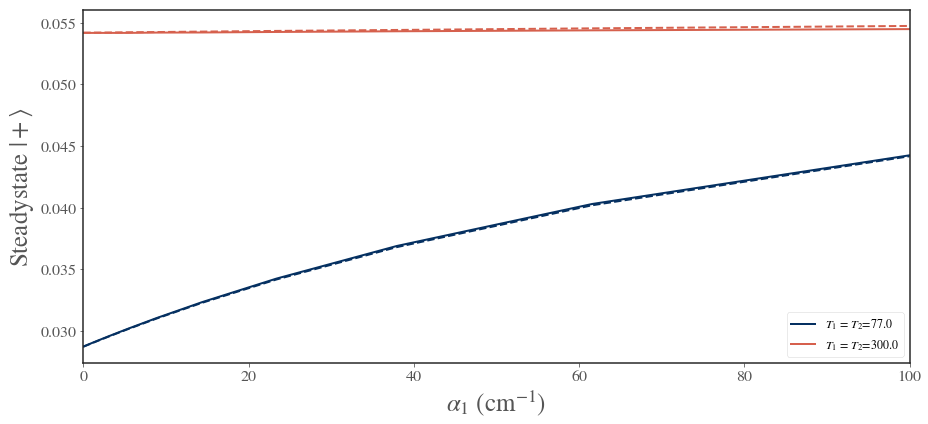

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_bright_2.pdf
plotting in new style


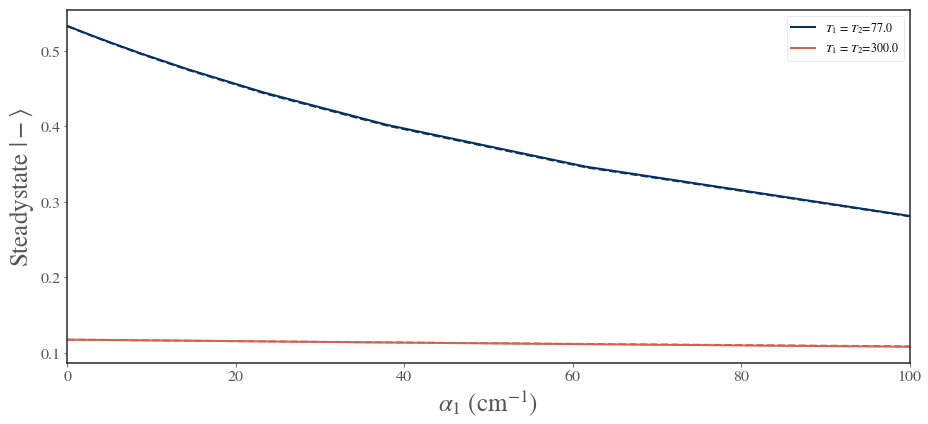

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_dark_2.pdf
plotting in new style


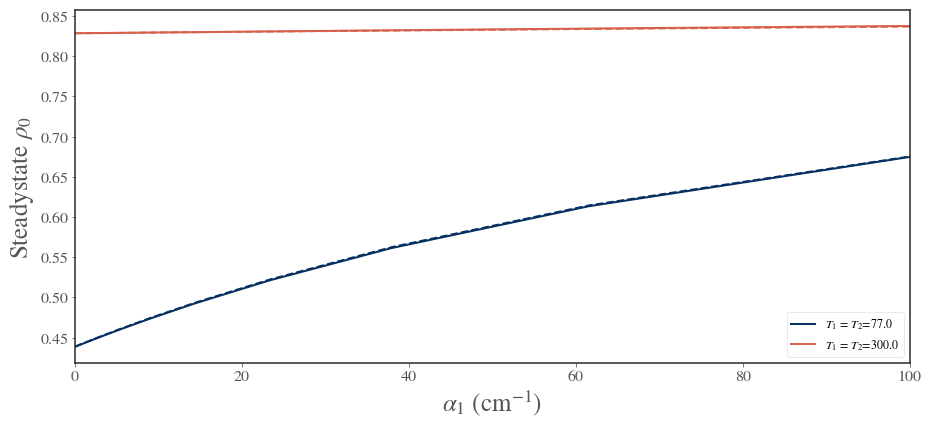

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_OO_2.pdf
plotting in new style


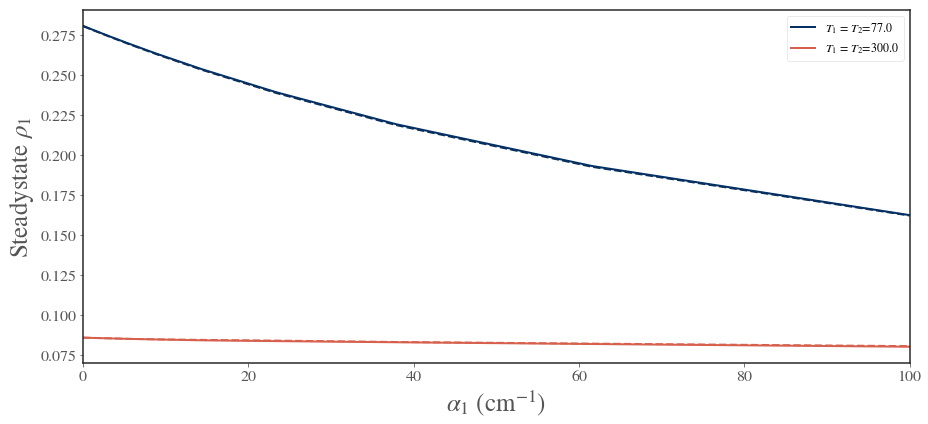

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_XO_2.pdf
plotting in new style


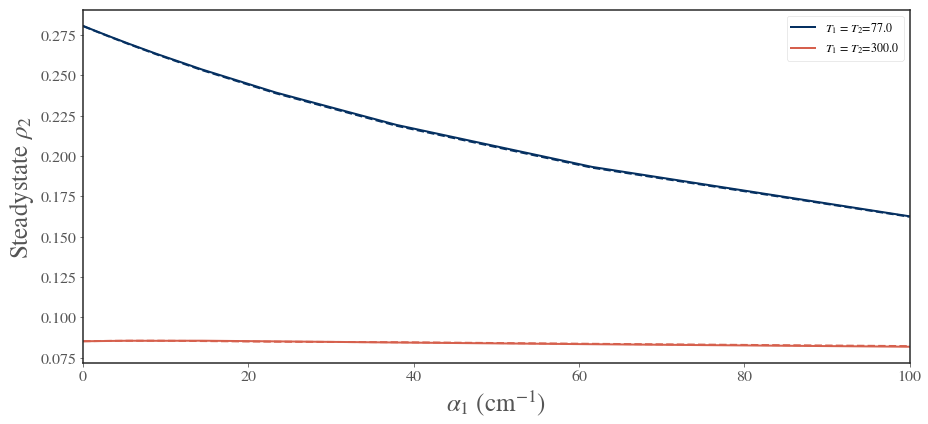

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_OX_2.pdf
plotting in new style


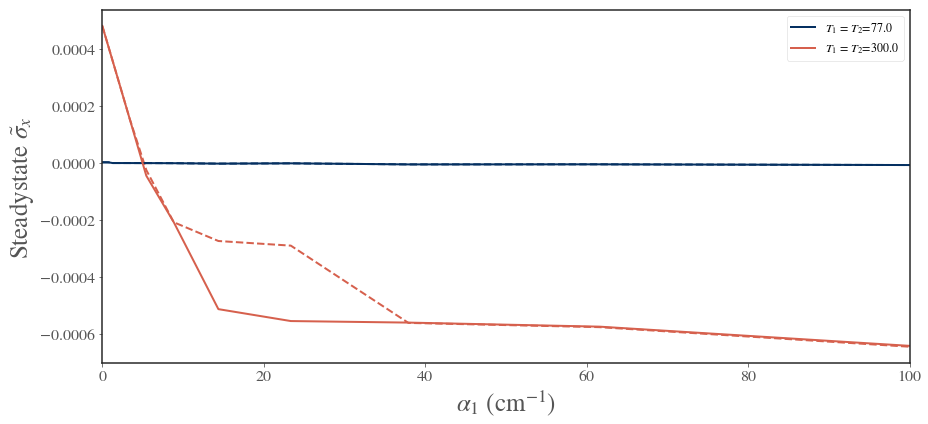

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_eig_x_2.pdf
plotting in new style


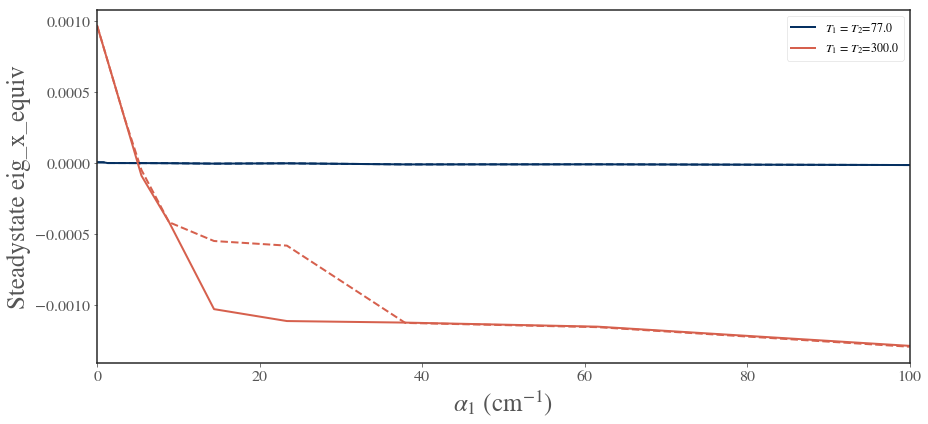

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_eig_x_equiv_2.pdf
plotting in new style


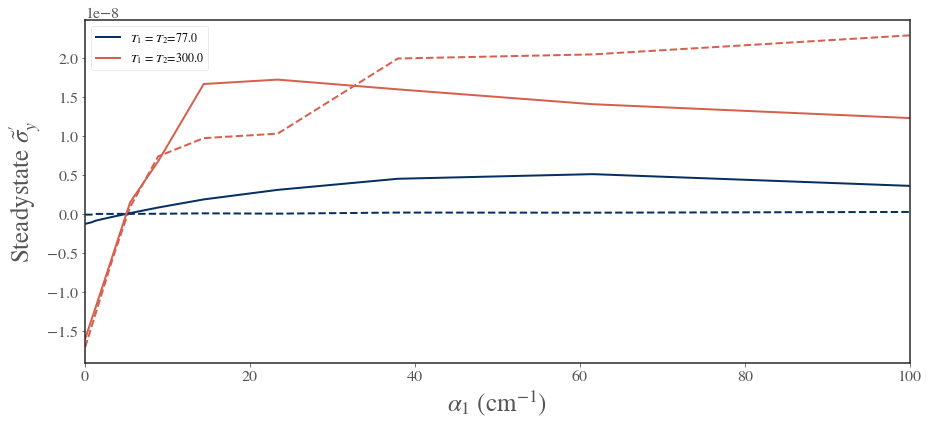

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_eig_y_2.pdf
plotting in new style


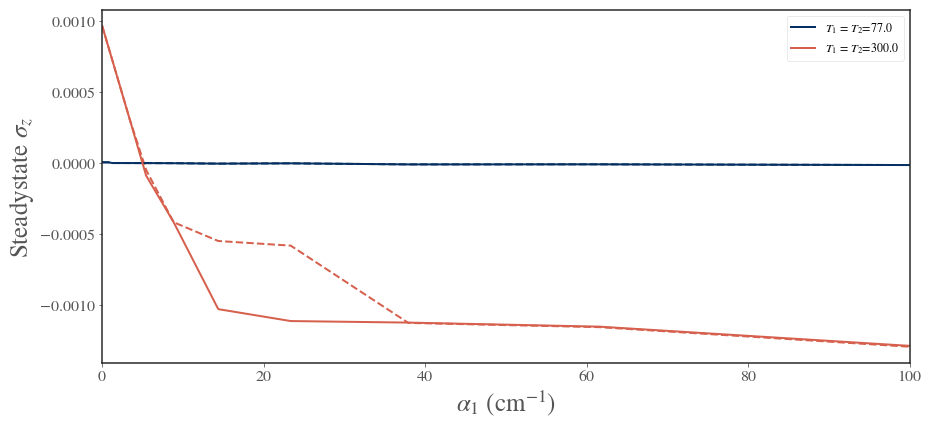

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_sigma_z_2.pdf
plotting in new style


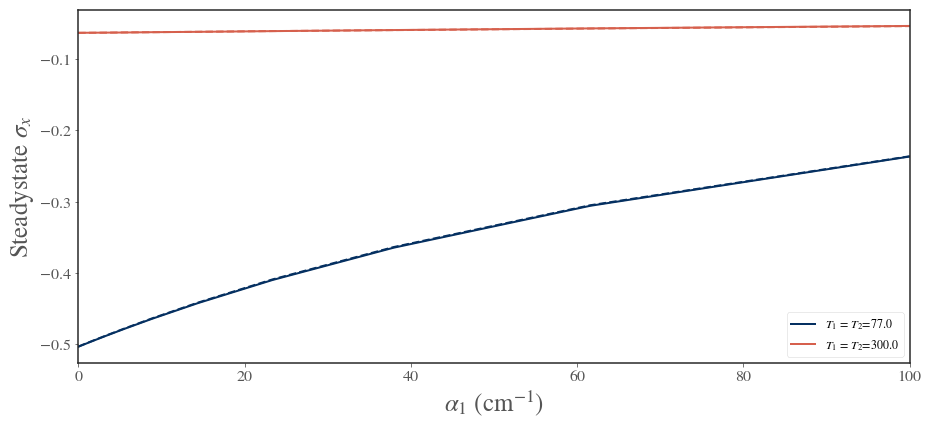

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_sigma_x_2.pdf
plotting in new style


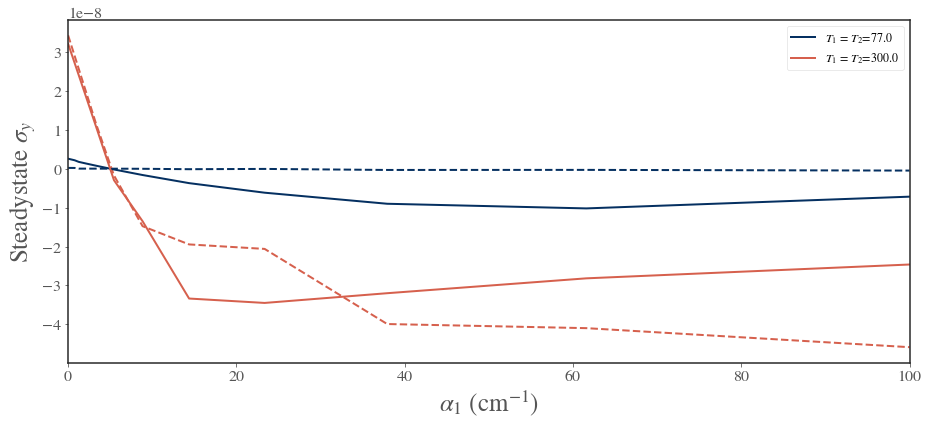

saved at PLOTS/heatmap_TphvAlpha_assymmetrical_sigma_y_2.pdf


In [4]:
num = 2
dirname = "heatmap_TphvAlpha_assymmetrical"
#heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
#                print_params=True, observable='DS/GS')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='bright')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='dark')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='OO')

heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='XO')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='OX')

heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_x')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_x_equiv')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='eig_y')

heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='sigma_z')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='sigma_x')
heatmap_plotter(num=num, plot_SD=False, dir_name=dirname,
                print_params=False, observable='sigma_y')

# Redfield comparison

In [33]:
import weak_phonons as wp
reload(wp)

w_2 = 1.4*ev_to_inv_cm
bias = 0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 0.01*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 10
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =5
wc = 100.
w_0 = 200.
site_basis = True
Gamma = (w_0**2)/wc
rho_s = []
rho_wc = []
phonons = np.logspace(-1,np.log10(20),8)

for alpha in phonons:
    PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                          V = V, alpha=alpha,
                          T_EM=6000., T_ph =180., alpha_EM=alpha_EM, shift=True,
                          num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                          silent=True, exc_diff=0)
    energies, states = exciton_states(PARAMS)
    eig_x = states[0]*states[1].dag()+states[1]*states[0].dag()
    dark = states[0]*states[0].dag()
    #print PARAMS.keys()
    #L = wp.L_weak_phonon_SES(PARAMS)
    H, L = wp.get_wc_H_and_L(PARAMS, silent=True, threshold=0.)
    
    Hs, Ls, Ladd = get_H_and_L(PARAMS, silent=True, threshold=0.)
    rho_s.append(steadystate(Hs[1], [Ls]))
    rho_wc.append(steadystate(H, [L]))
    #print ss.diag()
print "Calculation complete"

Weak coupling Liouvillian took 3.54 seconds
Weak coupling Liouvillian took 4.24 seconds
Weak coupling Liouvillian took 5.67 seconds
Weak coupling Liouvillian took 7.14 seconds
Weak coupling Liouvillian took 10.33 seconds
Weak coupling Liouvillian took 12.65 seconds
Weak coupling Liouvillian took 15.01 seconds
Weak coupling Liouvillian took 18.09 seconds
Calculation complete


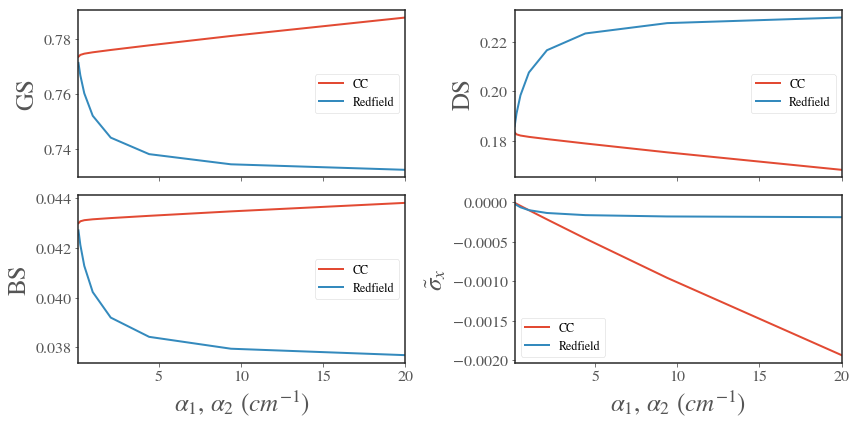

In [45]:
bright = states[1]*states[1].dag()
ops = make_expectation_operators(PARAMS)

f, ((ax1, ax2),(ax3, ax4))  = plt.subplots(2, 2, sharex=True, figsize=(12,6))

ax1.plot(phonons, [(r*ops['OO']).tr() for r in rho_s], label='CC')
ax1.plot(phonons, [(r*OO_proj).tr() for r in rho_wc], label='Redfield')
#plt.xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax1.set_ylabel(r"GS")
ax1.set_xlim(phonons[0], phonons[-1])
ax1.legend()

ax2.plot(phonons, [(r*ops['dark']).tr() for r in rho_s], label='CC')
ax2.plot(phonons, [(r*dark).tr() for r in rho_wc], label='Redfield')
#ax2.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax2.set_ylabel(r"DS")
ax2.legend()


ax3.plot(phonons, [(r*ops['bright']).tr() for r in rho_s], label='CC')
ax3.plot(phonons, [(r*bright).tr() for r in rho_wc], label='Redfield')
ax3.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax3.set_ylabel(r"BS")
ax3.legend()


ax4.plot(phonons, [(r*ops['eig_x']).tr() for r in rho_s], label='CC')
ax4.plot(phonons, [(r*eig_x).tr() for r in rho_wc], label='Redfield')
ax4.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
ax4.set_ylabel(r"$\tilde{\sigma}_x$")
ax4.legend()

plt.savefig("PLOTS/Redfield-CC.pdf")

In [ ]:
def populations_plotter(ss_info_params=False, num=-1, plot_SD=True, dir_name="heatmap", 
                     print_params=False, observable='sigma_x'):
    if num>=0:
        ss_array, PARAMS, info_array = heatmap_loader(num, dir_name=dir_name)
        
    if ss_info_params:
        if num>=0:
            print "Not loading saved data, using data from arguments instead"
        ss_array,info_array, PARAMS = ss_info_params[0], ss_info_params[1], ss_info_params[2]
    info = info_array[0][0]
    #print info
    
    try:
        # To catch an old bug where these were in "info" not in PARAMS
        keys = ['x_values', 'y_values', 'y_axis_parameters', 'x_axis_parameters']
        PARAMS.update(dict((key, info[key]) for key in keys))
    except Exception as err:
        print "plotting in new style"
    if plot_SD:
        plot_UD_SD(PARAMS["Gamma_1"], PARAMS["alpha_1"], PARAMS["w0_1"], eps=8000.)
    #print PARAMS
    ss_array = steadystate_observable(ss_array, PARAMS, observable)
    
    f, axes = plt.subplots(1,1, figsize=(13,6))
    for i, y_val in enumerate(PARAMS['y_values']):
        x_values = PARAMS['x_values']

        axes.plot(x_values, ss_array[i], 
                  label=str(PARAMS['y_axis_parameters'])+"="+str(y_val))
    if print_params:
        print_PARAMS(PARAMS)
    
    plt.xlabel(r', ($cm^{-1}$)'.join(r"\\"+PARAMS['x_axis_parameters']))
    plt.ylabel("Steadystate "+observable)
    #plt.ylabel(', '.join(info['y_axis_parameters']))
    plt.legend()
    plt.grid()
    plot_filename = 'PLOTS/'+dir_name+'_'+str(num)+'.pdf'
    plt.savefig(plot_filename)
    print "saved at {}".format(plot_filename)
    plt.show()

In [ ]:
ss_info_params = [ss_array, info_array, PARAMS]

heatmap_plotter(ss_info_params=ss_info_params, plot_SD=False,
                print_params=False, observable='sigma_x')

# Comparing SS solution methods (direct, inverse power, eigen)

In [ ]:
from qutip import build_preconditioner

def method_plotter(N_vals, data_dict, info_dict, ax1, ax2, linestyle="solid"):
    lw=1.
    if linestyle == 'dashed':
        lw=1.8
    for i, key in enumerate(data_dict.keys()):
        ax1.plot(N_vals, data_dict[key], label=key, color=colourWheel[i], ls=linestyle, linewidth=lw)
        #print info_dict[key]
        ax2.plot(N_vals, info_dict[key], label=key, color=colourWheel[i], ls=linestyle, linewidth=lw)
    ax1.legend()
    ax2.legend()
    ax1.set_ylabel("Coherence")
    ax2.set_ylabel("Solution time")


def method_comparison(N_i, N_f, plot=False, site_basis=True):
    methods = ['direct']
    data_dict = dict()
    info_dict = dict()
    N_vals = range(N_i, N_f)
    for exc_diff in [0,3,4]:
        for N in N_vals:
            PARAMS.update({'N_1':N, 'N_2':N, 'exc':int(2*N-exc_diff)})
            H, L = get_H_and_L(PARAMS,silent=False, threshold=1e-7, site_basis=site_basis)
            exps = make_expectation_operators(PARAMS, site_basis=site_basis)
            for method in methods:
                try:
                    M=None

                    if "iterative" in method:
                        ti = time.time()
                        M = build_preconditioner(H[1], [L], use_rcm=True, ILU_MILU='smilu_2')
                        print("Building preconditioner took {} seconds".format(time.time()-ti))
                    ss, full_info = calculate_steadystate(H, L, method=method, persistent=True)
                    info = full_info['solution_time']

                    coh = (exps['sigma_x']*ss).tr().real
                    try:
                        data_dict[exc_diff].append(coh)
                        info_dict[exc_diff].append(info)
                    except KeyError:
                        data_dict[exc_diff] = [coh]
                        info_dict[exc_diff] = [info]
                except Exception as err:
                    print( "{} failed due to : {}".format(method, err))
                    try:
                        data_dict[exc_diff].append(None)
                        info_dict[exc_diff].append(None)
                    except KeyError:
                        data_dict[exc_diff] = [None]
                        info_dict[exc_diff] = [None]
    #if plot:
    #    method_plotter(N_vals, data_dict, info_dict)
    return N_vals, data_dict, info_dict

N_vals, data_dict_sb, info_dict_sb = method_comparison(3,7)
#N_vals, data_dict_eb, info_dict_eb = method_comparison(3,7, site_basis=False)

f, (ax1, ax2) = plt.subplots(2,1, figsize=(10,7))
method_plotter(N_vals, data_dict_sb, info_dict_sb, ax1, ax2)
#method_plotter(N_vals, data_dict_eb, info_dict_eb, ax1, ax2, linestyle="dashed")


# Plotting methods

In [ ]:
heatmap_plotter(2, plot_SD=False, dir_name='heatmap_excvN', 
                     print_params=False, observable='')